# Supervised Repertoire Classification

While solving a sequence classification can be useful in the cases where the label applies to every sequence in a sample (such as in tetramer-sorted T-cells), there are times where the label may truly only apply to a set of sequences. For example, in the case where one may sequence tumor-infiltrating lymphocytes (TIL) and  there is a label at the repertoire/sample level such as which therapy the sample received. In this case, there may be a structural signature within a set of sequences that is predictive but not every single sequence has that signature. This is a case where we want to learn what is the structural signature buried in a set of sequenes and which sequences carry this signature.

To demo this utility of a repertoire/sample level classifier, we will first upload dat from the Rudqvist dataseet. In this dataset, 20 mice with implanted tumors were treated with 4 modes of therapy (Control, 9H10, RT, or Combo). We want to know whether the TCRrepertoire from their tumors is predictive of the therapy they received.

In [1]:
import sys
sys.path.append('../../')
from DeepTCR.DeepTCR import DeepTCR_WF

# Instantiate training object
DTCR_WF = DeepTCR_WF('Tutorial')

#Load Data from directories
DTCR_WF.Get_Data(directory='../../Data/Rudqvist',Load_Prev_Data=False,aggregate_by_aa=True,
               aa_column_beta=1,count_column=2,v_beta_column=7,d_beta_column=14,j_beta_column=21)

Loading Data...
Embedding Sequences...
Data Loaded


Process ForkPoolWorker-16:
Process ForkPoolWorker-3:
Process ForkPoolWorker-33:
Process ForkPoolWorker-17:
Process ForkPoolWorker-23:
Process ForkPoolWorker-18:
Process ForkPoolWorker-9:
Process ForkPoolWorker-36:
Process ForkPoolWorker-32:
Process ForkPoolWorker-39:
Process ForkPoolWorker-10:
Process ForkPoolWorker-15:
Process ForkPoolWorker-27:
Process ForkPoolWorker-5:
Process ForkPoolWorker-20:
Process ForkPoolWorker-14:
Traceback (most recent call last):
Process ForkPoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-12:
Process ForkPoolWorker-37:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-29:
Traceback (most recent call last):
Process ForkPoolWorker-2:
Process ForkPoolWorker-35:
Process ForkPoolWorker-26:
Process ForkPoolWorker-21:
Process ForkPoolWorker-31:
Process ForkPoolWorker-38:
Process ForkPoolWorker-40:
Process ForkPoolWorker-30:
Proc

Following loading the data, we will split our data into test/train and then train the model.

In [2]:
DTCR_WF.Get_Train_Valid_Test(test_size=0.25)
DTCR_WF.Train()

W1004 20:48:29.909550 139995146635072 deprecation_wrapper.py:119] From ../../DeepTCR/functions/Layers.py:130: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1004 20:48:29.918837 139995146635072 deprecation_wrapper.py:119] From ../../DeepTCR/functions/Layers.py:140: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1004 20:48:29.921924 139995146635072 deprecation_wrapper.py:119] From ../../DeepTCR/functions/Layers.py:141: The name tf.sparse.placeholder is deprecated. Please use tf.compat.v1.sparse.placeholder instead.

W1004 20:48:29.930583 139995146635072 deprecation_wrapper.py:119] From ../../DeepTCR/functions/Layers.py:12: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W1004 20:48:29.932635 139995146635072 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (fro

Training_Statistics: 
 Epoch: 0 Training loss: 1.61578 Validation loss: 1.56924 Testing loss: 1.56026 Training Accuracy: 0.25 Validation Accuracy: 0.25 Testing Accuracy: 0.25 Testing AUC: 0.91667
Training_Statistics: 
 Epoch: 1 Training loss: 1.56478 Validation loss: 1.52729 Testing loss: 1.51791 Training Accuracy: 0.25 Validation Accuracy: 0.25 Testing Accuracy: 0.25 Testing AUC: 0.91667
Training_Statistics: 
 Epoch: 2 Training loss: 1.51916 Validation loss: 1.48931 Testing loss: 1.48005 Training Accuracy: 0.25 Validation Accuracy: 0.25 Testing Accuracy: 0.25 Testing AUC: 0.91667
Training_Statistics: 
 Epoch: 3 Training loss: 1.47777 Validation loss: 1.45522 Testing loss: 1.44644 Training Accuracy: 0.25 Validation Accuracy: 0.25 Testing Accuracy: 0.25 Testing AUC: 0.91667
Training_Statistics: 
 Epoch: 4 Training loss: 1.44084 Validation loss: 1.42605 Testing loss: 1.41791 Training Accuracy: 0.25 Validation Accuracy: 0.25 Testing Accuracy: 0.25 Testing AUC: 0.91667
Training_Statistics:

Following training, we can view the performance through plotting the ROC curves.

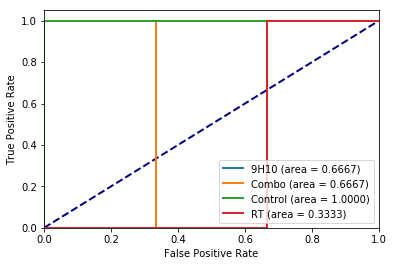

In [3]:
DTCR_WF.AUC_Curve()

You might notice that given how small this dataset is, doing one training split does not give us a good assesment for how predictive the TCR signature may be. In this case, we would want to use a K-fold cross validation to train on 16 of the samples and test on 4 and iterate until we've covered the entire cohort. When calling the K-fold cross validation command, one can provide the number of folds or if none is provided, it assumes a leave-one-out strategy. Therefore, we will set the folds to 5 where each fold will contain 4 samples. Here, we will also utilize an option for training where we apply a hinge loss to the training data where the per-sample loss is only used to penalize the model if it is above a certain threshold. This prevents over-fitting of the neural network. The idea here is that once a sample has been called correctly, there is no additional benefit to get it 'more right'. This is a particularly good training strategy when we are working with small datasets such as this one. We will also set the combine_train_valid parameter to True to combine what was originally the train and validation sets into one training set while leaving the test set for assessing performance. Otherwise, this method normally applies an early stopping criterion on the validation set. Since we have combined our train and validation sets together, we need to apply a stopping criterion on this training data. We will set the minimum loss before stopping training on the training data to 0.1. This means that when the average training loss hits 0.1, the neural network will stop training.

Here, we will also introduce other hyper-parameters we can modify including changing the size of the network. The size of the network parameter chooses the number of nodes for the 3 convolutional layers. Here, we will switch the sie of the network to 'small' which use 12,32,64 nodes respectively for the 3 conv layers. We will also leave out 4 samples for testing while we use 16 for training. Finally, we will also train our model with 64 concepts, a hyper-parameter of the multiple-instance learning (MIL) algorithm that we can change depending on the level of heterogeneity we expect in our data.

In [8]:
%%capture
folds = 5
size_of_net = 'small'
num_concepts=64
hinge_loss_t = 0.1
train_loss_min=0.1
DTCR_WF.K_Fold_CrossVal(combine_train_valid=True, hinge_loss_t = hinge_loss_t,train_loss_min = train_loss_min,folds=folds,
                       num_concepts=num_concepts, size_of_net=size_of_net)

We can then assess the performance once again through plotting the ROC curves.

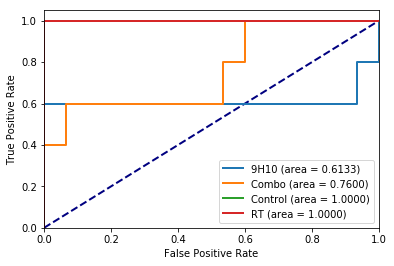

In [9]:
DTCR_WF.AUC_Curve()

We can also train our model in a Monte-Carlo fashion where we perform N number of monte-carlo simulation, randomly sampling train/test sets to train our model and assess predictive signature in our data in a more granular way.

In [10]:
%%capture
folds = 25
LOO = 4
epochs_min = 10
size_of_net = 'small'
num_concepts=64
hinge_loss_t = 0.1
train_loss_min=0.1

DTCR_WF.Monte_Carlo_CrossVal(folds=folds,LOO=LOO,epochs_min=epochs_min,num_concepts=num_concepts,size_of_net=size_of_net,
                             train_loss_min=train_loss_min,hinge_loss_t=hinge_loss_t,combine_train_valid=True)

Once again, we can look at the performance via a ROC curve.

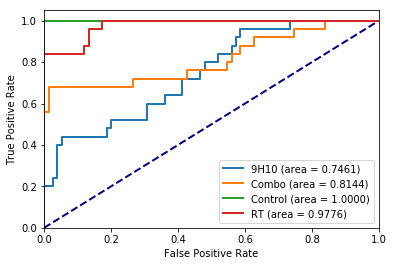

In [11]:
DTCR_WF.AUC_Curve()

Once our algorithm has been trained, we may want to see which sequences are the most strongly predicted for each label. To do this we will run the following command. The output of the command is a dictionary of dataframes within the object we can view. Additionally, these dataframes can be found in the results folder underneath the subdirectory 'Rep_Sequences'.

In [12]:
DTCR_WF.Representative_Sequences()

In [13]:
print(DTCR_WF.Rep_Seq['Control'])

      alpha            beta      v_beta      d_beta      j_beta v_alpha  \
12045  None   CASSLPASYEQYF  TCRBV12-01  unresolved  TCRBJ02-07    None   
11735  None    CASGAWGYEQYF  TCRBV13-02  unresolved  TCRBJ02-07    None   
11736  None  CASGLQMGQYEQYF  TCRBV13-02  TCBDD01-01  TCRBJ02-07    None   
12110  None   CASSDGESDTQYF  TCRBV13-01  TCBDD01-01  TCRBJ02-05    None   
12091  None   CASSLGSYAEQFF  TCRBV14-01  unresolved  TCRBJ02-01    None   
13044  None    CASGAWGYEQYF  TCRBV13-02  unresolved  TCRBJ02-07    None   
15210  None   CASSLGGRDEQYF  TCRBV03-01  TCBDD02-01  TCRBJ02-07    None   
14089  None    FASGAWGYEQYF  TCRBV13-02  unresolved  TCRBJ02-07    None   
15795  None    CASGAWGYEQYF  TCRBV13-02  unresolved  TCRBJ02-07    None   
17055  None   CASSLGLYAEQFF  TCRBV13-01  unresolved  TCRBJ02-01    None   

      j_alpha    Class         Sample      Freq  Counts           HLA  \
12045    None  Control  CONTROL-3.tsv  0.001773       2  [N, o, n, e]   
11735    None  Control  CONT

Furthermore, we may want to know which learned motifs are associated with a given label. To do this, we can run the following command with the label we want to know the predictive motifs for.

In [14]:
DTCR_WF.Motif_Identification('Control')

Motif Identification Completed


The motifs can then be found in fasta files in the results folder underneath (label)(alpha/beta)Motifs. These fasta fiels can then be used with "https://weblogo.berkeley.edu/logo.cgi" for motif visualization.